In [2]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [28]:
vehiculo = 'DA02'

In [29]:
path_rec = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\RECORRIDOS_.shp'
gdf_rec = gpd.read_file(path_rec)

In [30]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

97

In [31]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

10

In [32]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [33]:
lineas, names = leer_logs(contenido_filtrado)

In [34]:
lineas

[<LINESTRING (-63.199 -17.243, -63.199 -17.243, -63.199 -17.243, -63.199 -17....>,
 <LINESTRING (-63.199 -17.243, -63.199 -17.243, -63.199 -17.243, -63.199 -17....>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.18 -17.251, -63.18 -17.251, -63.18 -17.251, -63.18 -17.251,...>,
 <LINESTRING (-63.183 -17.245, -63.183 -17.245, -63.183 -17.245, -63.183 -17....>,
 <LINESTRING (-63.198 -17.241, -63.198 -17.241, -63.198 -17.241, -63.198 -17....>,
 <LINESTRING (-63.203 -17.241, -63.203 -17.241, -63.203 -17.241, -63.203 -17....>,
 <LINESTRING (-63.202 -17.244, -63.202 -17.244, -63.202 -17.244, -63.202 -17....>,
 <LINESTRING (-63.178 -17.275, -63.178 -17.275, -63.178 -17.275, -63.178 -17....>,
 <LINESTRING (-63.178 -17.275, -63.178 -17.275, -63.178 -17.275, -63.178 -17....>]

In [35]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")

In [36]:
gdf_lines.head(3)

,nombre,geometry
0,2025-09-08 09-14-44.tlog,"LINESTRING (-63.19862 -17.24271, -63.19862 -17..."
1,2025-09-08 10-30-13.tlog,"LINESTRING (-63.19862 -17.24271, -63.19862 -17..."
2,2025-09-08 19-44-56.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


<Axes: >

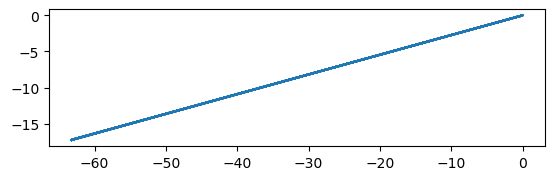

In [37]:
gdf_lines.plot()

In [38]:
gdf_lines.to_file('LINEAS.shp', driver="ESRI Shapefile")

In [39]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [40]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [41]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [42]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [43]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [44]:
gdf_lines['vehiculo'] = vehiculo

In [45]:
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-09-08 09-14-44.tlog,"LINESTRING (-63.19862 -17.24271, -63.19862 -17...",338,DA02
1,2025-09-08 09-14-44.tlog,"LINESTRING (-63.19863 -17.24273, -63.19863 -17...",595,DA02
2,2025-09-08 10-30-13.tlog,"LINESTRING (-63.19862 -17.24271, -63.19862 -17...",961,DA02


<Axes: >

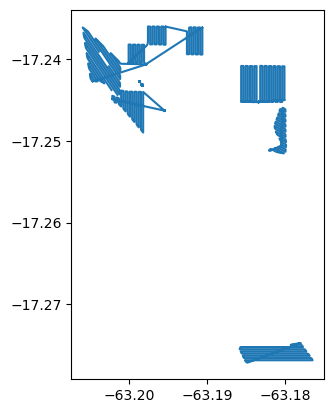

In [46]:
gdf_lines.plot()

In [47]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

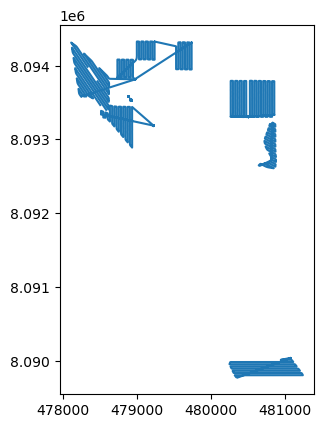

In [48]:
gdf_lines_utm.plot()

In [49]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [50]:
gdf_combined

,idd,nombre,vehiculo,num_vert,id,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,None,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,None,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,None,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,None,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,None,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...,...
437,0,2025-09-09 01-16-07.tlog,DA02,1181.0,NaN,NaN,"LINESTRING (478508.860 8093454.289, 478507.157..."
438,0,2025-09-09 01-16-07.tlog,DA02,3483.0,NaN,NaN,"LINESTRING (478973.500 8093817.055, 478973.426..."
439,0,2025-09-09 01-48-35.tlog,DA02,3494.0,NaN,NaN,"LINESTRING (481073.920 8090041.703, 481073.909..."
440,0,2025-09-09 01-48-35.tlog,DA02,661.0,NaN,NaN,"LINESTRING (481070.530 8090040.738, 481070.477..."


In [51]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert     float64
id            object
asignado      object
geometry    geometry
dtype: object

In [52]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")